In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import keras_tuner as kt
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras import Sequential, layers
from keras.layers import Dense, Dropout


In [3]:
# raw_data = pd.read_csv(r"../data/processed_data/undersampled_train.csv", index_col=0)
raw_data = pd.read_csv(r"../data/processed_data/oversampled_train.csv", index_col=0)

In [4]:
x = raw_data.drop(["TARGET"], axis=1)
y = raw_data.filter(["TARGET"], axis=1)

scaler = (
    StandardScaler()
)  # MinMaxScaler often made values = 0.0, which = lost features in training
x_scaled = scaler.fit_transform(x)
y = y.values  # we dont need to scale our binary classification

# x_scaled = x_scaled.reshape(x_scaled.shape[0], x_scaled.shape[1], )  # data needs to be 3D for a CNN

x_scaled.shape, y.shape

((480566, 120), (480566, 1))

In [5]:
def model_builder(hp):
    model = Sequential()

    # input layer
    model.add(Dense(units=x_scaled.shape[1], input_shape=(x_scaled.shape[1],)))

    # let the model decide how many layers it wants to have
    for i in range(hp.Int("num_dense_layers", min_value=2, max_value=5, step=1)):
        model.add(
            Dropout(hp.Float("dropout_" + str(i), min_value=0, max_value=0.5, step=0.1))
        )
        model.add(
            Dense(
                units=hp.Int("layer_" + str(i), min_value=32, max_value=1024, step=64),
                activation=hp.Choice("act_" + str(i), ["relu", "sigmoid"]),
            )
        )

    # output shape of the model the same as the number of features
    model.add(
        Dense((1), activation="sigmoid"),
    )

    # compile the model
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )

    return model


In [6]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)


In [11]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("accuracy", direction="max"),
    factor=3,
    max_epochs=15,
    directory=r"../logs/oversampled",
    project_name="Hyperband_v1.01",
)


INFO:tensorflow:Reloading Tuner from ../logs/oversampled\Hyperband_v1.01\tuner0.json


In [ ]:
tuner.search(
    x_scaled,
    y,
    batch_size=64,
    validation_split=0.2,
    callbacks=[earlyStop],
)


In [13]:
hpModel = tuner.get_best_models()[0]
hpModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               14520     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 672)               81312     
                                                                 
 dropout_1 (Dropout)         (None, 672)               0         
                                                                 
 dense_2 (Dense)             (None, 96)                64608     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0         
                                                                 
 dense_3 (Dense)             (None, 672)               6

In [15]:
trained_model = hpModel.fit(
    x_scaled, y, epochs=5, batch_size=32, callbacks=earlyStop
)

Epoch 1/5
15018/15018 [==============================] - 73s 5ms/step - loss: 0.2597 - accuracy: 0.8991
Epoch 2/5
15018/15018 [==============================] - 73s 5ms/step - loss: 0.2611 - accuracy: 0.8990
Epoch 3/5
15018/15018 [==============================] - 89s 6ms/step - loss: 0.2654 - accuracy: 0.8977
Epoch 4/5
15018/15018 [==============================] - 78s 5ms/step - loss: 0.2706 - accuracy: 0.8947
Epoch 5/5
15018/15018 [==============================] - 77s 5ms/step - loss: 0.2690 - accuracy: 0.8952


In [28]:
hpModel.save("Hyperband_v1.01")

INFO:tensorflow:Assets written to: Hyperband_v1.01\assets


In [29]:
model_performance = hpModel.evaluate(x_scaled, y)
print(f"Loss: {model_performance[0]}\nAccuracy: {model_performance[1]}")

15018/15018 [==============================] - 46s 3ms/step - loss: 0.2529 - accuracy: 0.9018
Test loss: [0.25292351841926575, 0.9018095135688782]


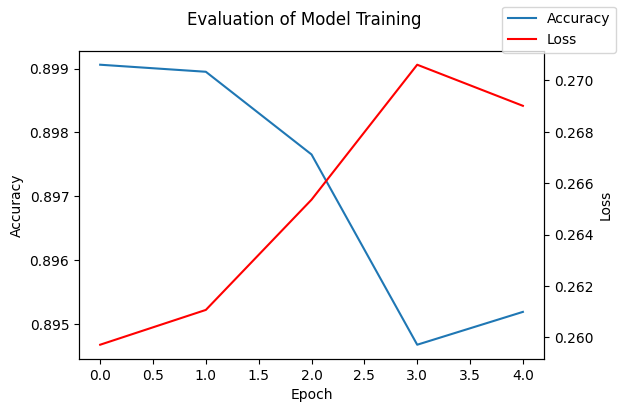

In [47]:
fig, (ax1) = plt.subplots(figsize=(6, 4))
fig.suptitle("Evaluation of Model Training")
ax2 = ax1.twinx()

ax1.plot(trained_model.history["accuracy"], label="Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")

ax2.plot(trained_model.history["loss"], color="r", label="Loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")

fig.legend()